In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torch.optim as optim
import time
import os
import copy
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
basePath = '/content/'

modelSave = basePath+'weights.pth'

data_dir = basePath+'Sample'
#data_dir = basePath+'Dataset_2'

batch_size = 8
num_epochs = 1
input_size = 224
NUM_CLASSES = 3

In [ ]:
image_types = ["Covid-19","No_findings","Pneumonia"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def resize_images(image_dir):
  for im_type in image_types:
    # Iterate through each image file in each image_type folder
    #  glob reads in any image with the extension "image_dir/im_type/*"
    for file in glob.glob(os.path.join(image_dir, im_type, "*")):
        im = Image.open(file)
        f, e = os.path.splitext(file)
        imResize = im.resize((input_size,input_size), Image.ANTIALIAS)
        os.remove(file)
        imResize.save(f + '.png', 'PNG', quality=90)

In [ ]:
'''!cp -R '/content/drive/My Drive/COVID-19/Sample' '/content/'
#!cp -R '/content/drive/My Drive/COVID-19/Dataset_2' '/content/'
resize_images(data_dir+'/train')
resize_images(data_dir+'/val')'''

"!cp -R '/content/drive/My Drive/COVID-19/Sample' '/content/'\n#!cp -R '/content/drive/My Drive/COVID-19/Dataset_2' '/content/'\nresize_images(data_dir+'/train')\nresize_images(data_dir+'/val')"

In [ ]:
'''resize_images(data_dir+'/train')
resize_images(data_dir+'/val')'''

"resize_images(data_dir+'/train')\nresize_images(data_dir+'/val')"

In [ ]:
#!rm -R 'Sample'

In [ ]:
class DenseNet121(nn.Module):
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x
    

class CovidAID(DenseNet121):
    def __init__(self):
        #NUM_CLASSES = 3
        super(CovidAID, self).__init__(NUM_CLASSES)

In [ ]:
def getTrainDataLoaders():
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    idx2label_dict = {v: k for k, v in image_datasets['train'].class_to_idx.items()}
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    return idx2label_dict,dataloaders_dict

In [ ]:
def getUpdatablePara(model):
    params_to_update = model.parameters()
    #print("Params to learn:")
    params_to_update = []
    for name,param in model.named_parameters():
        if  param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
    return params_to_update

In [ ]:
def getClassCount(dataloaders,phase):
    class_count = [0]*NUM_CLASSES
    for _, labels in dataloaders[phase]:
        unique_elements, counts_elements = np.unique(labels, return_counts=True)
        for i in range(unique_elements.shape[0]):
            class_count[unique_elements[i]] += counts_elements[i]

    return np.asarray(class_count)

In [ ]:
def cross_entropy(target,pred,pos,total):
    out = ((total-pos)/total)*target*torch.log2(pred) + ((pos)/total)*(1-target)*torch.log2(1-pred)
    return -torch.sum(out)

In [ ]:
def loss(labels,outputs,class_count):
    one_hot = torch.nn.functional.one_hot(labels,num_classes = NUM_CLASSES)
    total = np.sum(class_count)
    flag = True
    total_loss = torch.tensor(0)
    for i in range(outputs.shape[1]):
        temp = cross_entropy(one_hot[:,i],outputs[:,i],class_count[i],total)
        if flag:
            total_loss = temp
            flag = False
        else:
            total_loss += temp
    return total_loss

In [ ]:
y_true = np.asarray([],dtype=np.int32)
y_pred = np.asarray([],dtype=np.int32)

In [ ]:
def train_model(model, dataloaders, optimizer, num_epochs=25):
    global y_true
    global y_pred
    since = time.time()

    val_acc_history = {'train':[],'val':[]}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['val']:
        #for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            class_count = getClassCount(dataloaders,phase)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    lossVar = loss(labels,outputs,class_count)
                    #lossVar = criterion(outputs,labels)
                    _, preds = torch.max(outputs, 1)
                    #print(preds.numpy(),labels.data.numpy())
                    y_true = np.append(y_true,labels.data.detach().cpu().numpy())
                    y_pred = np.append(y_pred,preds.detach().cpu().numpy())
                    #print(y_true,y_pred)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        lossVar.backward()
                        optimizer.step()

                # statistics
                running_loss += lossVar.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            val_acc_history[phase].append(epoch_acc.item())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
model = CovidAID()
#model.load_state_dict( torch.load(modelSave))
model = model.to(device)

In [ ]:
#print(model)

In [ ]:
idx2label_dict,dataloaders = getTrainDataLoaders()
params_to_update = getUpdatablePara(model)

Initializing Datasets and Dataloaders...


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.00001)

model_out, hist = train_model(model, dataloaders, optimizer_ft, num_epochs=num_epochs)

torch.save(model_out.state_dict(), modelSave)

Epoch 0/0
----------
val Loss: 8.4425 Acc: 0.3333

Training complete in 0m 1s
Best val Acc: 0.333333


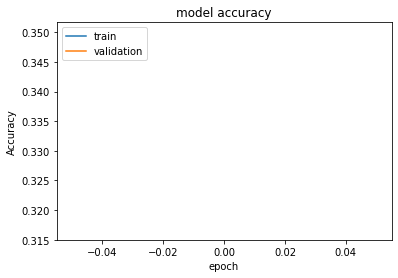

In [ ]:
# summarize history for loss
plt.plot(hist['train'])
plt.plot(hist['val'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Recall**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [ ]:
def get_key(mydict,val): 
    for key, value in mydict.items(): 
         if val == value: 
             return key 

In [ ]:
def calReCall(y_true,y_pred,idx2label_dict,class_name):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [idx2label_dict[int(i)] for i in "012"],
                  columns = [idx2label_dict[int(i)] for i in "012"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,linewidths=.5)
    id = get_key(idx2label_dict,class_name)
    out = np.sum(cm, axis=1)
    return cm[id][id]/out[id]

Recall:  0.0


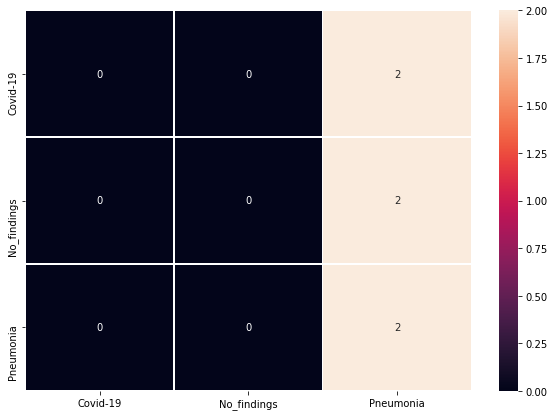

In [ ]:
recallVal = calReCall(y_true,y_pred,idx2label_dict,'Covid-19')
print("Recall: ",recallVal)